In [1]:
import random

from finrl.meta.env_portfolio_allocation import env_portfolio

import pandas as pd
import numpy as np
import gym
from typing import Callable, Tuple
from collections import defaultdict
from tqdm import trange


In [2]:
def generate_episode(env: gym.Env, policy: Callable, es: bool = False):
    """A function to generate one episode and collect the sequence of (s, a, r) tuples

    This function will be useful for implementing the MC methods

    Args:
        env (gym.Env): a Gym API compatible environment
        policy (Callable): A function that represents the policy.
        es (bool): Whether to use exploring starts or not
    """
    episode = []
    state = env.reset()
    while True:
        if es and len(episode) == 0:
            action = env.action_space.sample()
        else:
            action = policy(state)

        next_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        if done:
            break
        state = next_state

    return episode


In [26]:
############STUFF GRABBED FROM FINRL TUTORIAL
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
import datetime

from finrl import config
from finrl import config_tickers
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from environments.portfolio_without_softmax import StockPortfolioEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline, convert_daily_return_to_pyfolio_ts
from finrl.meta.data_processor import DataProcessor
from finrl.meta.data_processors.processor_yahoofinance import YahooFinanceProcessor
import sys

## 2.4. Create Folders
import os

if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

print(config_tickers.DOW_30_TICKER)
#dp = YahooFinanceProcessor()
#df = dp.download_data

df = YahooDownloader(start_date='2008-01-01',
                     end_date='2021-10-31',
                     ticker_list=config_tickers.DOW_30_TICKER).fetch_data()

df.head()
df.shape


['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%******

(101615, 8)

In [4]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    use_turbulence=False,
    user_defined_feature=False)

df = fe.preprocess_data(df)
df.shape
df.head()

Successfully added technical indicators


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,2008-01-02,7.116786,7.152143,6.876786,5.898641,1079178800,AAPL,2,0.0,5.903858,5.896149,100.0,-66.666667,100.0,5.898641,5.898641
3483,2008-01-02,46.599998,47.040001,46.259998,33.761425,7934400,AMGN,2,0.0,5.903858,5.896149,100.0,-66.666667,100.0,33.761425,33.761425
6966,2008-01-02,52.090000,52.320000,50.790001,39.587997,8053700,AXP,2,0.0,5.903858,5.896149,100.0,-66.666667,100.0,39.587997,39.587997
10449,2008-01-02,87.570000,87.839996,86.000000,63.481617,4303000,BA,2,0.0,5.903858,5.896149,100.0,-66.666667,100.0,63.481617,63.481617
13932,2008-01-02,72.559998,72.669998,70.050003,45.605473,6337800,CAT,2,0.0,5.903858,5.896149,100.0,-66.666667,100.0,45.605473,45.605473


In [5]:
df.tail()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
83591,2021-10-29,162.130005,162.440002,160.660004,153.936371,1314100,TRV,4,1.424914,156.635669,144.752570,55.691946,130.838046,19.622993,149.630910,150.155365
87074,2021-10-29,454.410004,461.390015,453.059998,447.971100,2497800,UNH,4,12.812449,459.914531,366.732075,67.009707,145.348178,52.064871,406.440830,405.562354
90557,2021-10-29,52.500000,53.049999,52.410000,46.802311,17763200,VZ,4,-0.170568,48.086327,45.189776,46.685040,-39.966294,12.569826,46.875140,47.474613
94040,2021-10-29,46.860001,47.279999,46.770000,41.523605,4999000,WBA,4,-0.169815,44.202654,40.524219,45.913454,-97.394876,0.268701,42.391108,42.889372
97523,2021-10-29,147.910004,150.100006,147.559998,144.852402,7340900,WMT,4,1.795640,147.887256,129.205263,59.710653,130.750217,35.423702,138.057021,140.642315


In [6]:

## Add covariance matrix as states
# add covariance matrix as states
df = df.sort_values(['date', 'tic'], ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback = 252
for i in range(lookback, len(df.index.unique())):
    data_lookback = df.loc[i - lookback:i, :]
    price_lookback = data_lookback.pivot_table(index='date', columns='tic', values='close')
    return_lookback = price_lookback.pct_change().dropna()
    return_list.append(return_lookback)

    covs = return_lookback.cov().values
    cov_list.append(covs)

df_cov = pd.DataFrame({'date': df.date.unique()[lookback:], 'cov_list': cov_list, 'return_list': return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date', 'tic']).reset_index(drop=True)

df.shape
df.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2008-12-31,3.070357,3.133571,3.047857,2.583910,607541200,AAPL,2,-0.082603,3.093651,2.454292,42.254794,-80.462429,16.129793,2.749560,2.861671,"[[0.001348969935888754, 0.0004284121076667737,...",tic AAPL AMGN AXP ...
1,2008-12-31,57.110001,58.220001,57.060001,41.839527,6287200,AMGN,2,0.156757,42.707029,40.853195,51.060628,51.523483,10.432018,41.058034,40.603775,"[[0.001348969935888754, 0.0004284121076667737,...",tic AAPL AMGN AXP ...
2,2008-12-31,17.969999,18.750000,17.910000,14.580749,9625600,AXP,2,-0.935582,18.646868,12.660477,42.554834,-75.437684,25.776759,15.744065,17.616375,"[[0.001348969935888754, 0.0004284121076667737,...",tic AAPL AMGN AXP ...
3,2008-12-31,41.590000,43.049999,41.500000,32.005890,5443100,BA,2,-0.279799,32.174384,28.867835,47.440237,156.994825,5.366299,30.327213,32.389914,"[[0.001348969935888754, 0.0004284121076667737,...",tic AAPL AMGN AXP ...
4,2008-12-31,43.700001,45.099998,43.700001,29.608664,6277400,CAT,2,0.655611,30.348089,25.455650,51.205325,98.374219,26.331746,26.689551,26.423593,"[[0.001348969935888754, 0.0004284121076667737,...",tic AAPL AMGN AXP ...


In [7]:
## Training data split: 2009-01-01 to 2020-07-01
train = data_split(df, '2009-01-01', '2020-07-01')
#trade = data_split(df, '2020-01-01', config.END_DATE)
train.head()

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,2009-01-02,3.067143,3.251429,3.041429,2.747390,746015200,AAPL,4,-0.070153,3.080129,2.452222,45.440189,-32.212959,2.140064,2.750408,2.862473,"[[0.0013661513593181544, 0.0004339376246822945...",tic AAPL AMGN AXP ...
0,2009-01-02,58.590000,59.080002,57.750000,42.737900,6547900,AMGN,4,0.232163,42.852624,40.817724,52.756873,92.828091,0.814217,41.122031,40.691922,"[[0.0013661513593181544, 0.0004339376246822945...",tic AAPL AMGN AXP ...
0,2009-01-02,18.570000,19.520000,18.400000,15.193845,10955700,AXP,4,-0.832049,18.463252,12.644441,43.957537,-42.853118,16.335101,15.742755,17.499519,"[[0.0013661513593181544, 0.0004339376246822945...",tic AAPL AMGN AXP ...
0,2009-01-02,42.799999,45.560001,42.779999,33.941093,7010200,BA,4,-0.002008,32.948626,28.452129,50.822033,272.812762,20.494464,30.469479,32.344129,"[[0.0013661513593181544, 0.0004339376246822945...",tic AAPL AMGN AXP ...
0,2009-01-02,44.910000,46.980000,44.709999,31.093395,7117200,CAT,4,0.833183,30.850186,25.434767,53.661257,129.524659,34.637448,26.926403,26.424175,"[[0.0013661513593181544, 0.0004339376246822945...",tic AAPL AMGN AXP ...


In [8]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym_random = StockPortfolioEnv(df = train, **env_kwargs)


Stock Dimension: 28, State Space: 28


In [9]:
import random
def random_agent(env: StockPortfolioEnv):
    env.reset()
    terminal = False
    while not terminal:
        action = [0] * len(env.action_space.sample())
        action[random.randint(0,  len(env.action_space.sample()) - 1)] = 1
        state, reward, terminal, _, _ = env.step(action)
    return env

In [10]:
env_rand_post_training = random_agent(e_train_gym_random)

begin_total_asset:1000000
end_total_asset:6581143.849883328
Sharpe:  0.7425012846171369


In [11]:
from agents.single_stock_tabular import sarsa_single_stock

In [42]:
assets = []
episodes_for_training = list(range(1,51, 5))
for e in episodes_for_training:
    # todo, Need to test performance on 
    e_train_gym_single_stock_sarsa = StockPortfolioEnv(df = train, **env_kwargs)
    sarsa_single_stock(e_train_gym_single_stock_sarsa, num_episodes=e, gamma=0.99, epsilon=0.1, step_size=0.5, stock=0)
    assets.append(e_train_gym_single_stock_sarsa.asset_memory)
    e_train_gym_single_stock_sarsa.reset()
    

begin_total_asset:1000000
end_total_asset:4212775.105744878
Sharpe:  0.9164115099514064


Episode:  17%|█▋        | 1/6 [00:10<00:52, 10.52s/it]

begin_total_asset:1000000
end_total_asset:5999391.378841401
Sharpe:  0.8126398668864684


Episode:  33%|███▎      | 2/6 [00:20<00:41, 10.48s/it]

begin_total_asset:1000000
end_total_asset:5797592.406629567
Sharpe:  0.9963880200527166


Episode:  50%|█████     | 3/6 [00:31<00:31, 10.48s/it]

begin_total_asset:1000000
end_total_asset:12958750.598497951
Sharpe:  1.2583529574833041


Episode:  67%|██████▋   | 4/6 [00:42<00:21, 10.58s/it]

begin_total_asset:1000000
end_total_asset:11965933.199993126
Sharpe:  1.217338490095002


Episode:  83%|████████▎ | 5/6 [00:52<00:10, 10.58s/it]

begin_total_asset:1000000
end_total_asset:4390355.131794978
Sharpe:  0.7539299787735511


begin_total_asset:1000000
end_total_asset:4016262.0689071477
Sharpe:  0.9739134920434979


Episode:   9%|▉         | 1/11 [00:10<01:46, 10.63s/it]

begin_total_asset:1000000
end_total_asset:2891654.893398825
Sharpe:  0.6710930709738285


Episode:  18%|█▊        | 2/11 [00:21<01:34, 10.50s/it]

begin_total_asset:1000000
end_total_asset:8615119.231724177
Sharpe:  1.071881955627904


Episode:  27%|██▋       | 3/11 [00:31<01:22, 10.29s/it]

begin_total_asset:1000000
end_total_asset:5195437.572551234
Sharpe:  0.8239374647882466


Episode:  36%|███▋      | 4/11 [00:41<01:11, 10.23s/it]

begin_total_asset:1000000
end_total_asset:5000589.00708292
Sharpe:  0.9874355371550684


Episode:  45%|████▌     | 5/11 [00:51<01:00, 10.11s/it]

begin_total_asset:1000000
end_total_asset:22683744.98393506
Sharpe:  1.599393465613695


Episode:  55%|█████▍    | 6/11 [01:01<00:50, 10.04s/it]

begin_total_asset:1000000
end_total_asset:9263024.864975497
Sharpe:  1.1827527003070208


Episode:  64%|██████▎   | 7/11 [01:10<00:39,  9.97s/it]

begin_total_asset:1000000
end_total_asset:6579814.157693506
Sharpe:  1.0505244492316415


Episode:  73%|███████▎  | 8/11 [01:20<00:30, 10.00s/it]

begin_total_asset:1000000
end_total_asset:3451688.19477628
Sharpe:  0.9708718556741667


Episode:  82%|████████▏ | 9/11 [01:30<00:19,  9.99s/it]

begin_total_asset:1000000
end_total_asset:3227465.0330006215
Sharpe:  0.65647438987161


Episode:  91%|█████████ | 10/11 [01:41<00:10, 10.05s/it]

begin_total_asset:1000000
end_total_asset:4087887.3087572595
Sharpe:  0.727664172065165


begin_total_asset:1000000
end_total_asset:10897165.526574634
Sharpe:  1.1246288031902452


Episode:   6%|▋         | 1/16 [00:09<02:29,  9.98s/it]

begin_total_asset:1000000
end_total_asset:4943391.026570566
Sharpe:  0.8306127980021335


Episode:  12%|█▎        | 2/16 [00:20<02:20, 10.06s/it]

begin_total_asset:1000000
end_total_asset:8272607.77023296
Sharpe:  1.3403032562739934


Episode:  19%|█▉        | 3/16 [00:30<02:10, 10.02s/it]

begin_total_asset:1000000
end_total_asset:2771540.0542463656
Sharpe:  0.6040994501881886


Episode:  25%|██▌       | 4/16 [00:39<01:59,  9.98s/it]

begin_total_asset:1000000
end_total_asset:3037039.0605987194
Sharpe:  0.6951918924252803


Episode:  31%|███▏      | 5/16 [00:50<01:50, 10.03s/it]

begin_total_asset:1000000
end_total_asset:5007245.86615637
Sharpe:  0.8359145975496669


Episode:  38%|███▊      | 6/16 [01:00<01:41, 10.13s/it]

begin_total_asset:1000000
end_total_asset:5169270.84863519
Sharpe:  0.897308381434091


Episode:  44%|████▍     | 7/16 [01:10<01:31, 10.11s/it]

begin_total_asset:1000000
end_total_asset:4952436.543762432
Sharpe:  0.8291356764569517


Episode:  50%|█████     | 8/16 [01:20<01:21, 10.13s/it]

begin_total_asset:1000000
end_total_asset:8698033.514224773
Sharpe:  1.08685657050412


Episode:  56%|█████▋    | 9/16 [01:30<01:10, 10.12s/it]

begin_total_asset:1000000
end_total_asset:6408662.68237694
Sharpe:  0.9835090922655665


Episode:  62%|██████▎   | 10/16 [01:40<01:00, 10.08s/it]

begin_total_asset:1000000
end_total_asset:4667889.066105884
Sharpe:  0.7738329272629423


Episode:  69%|██████▉   | 11/16 [01:50<00:50, 10.02s/it]

begin_total_asset:1000000
end_total_asset:6677702.046333626
Sharpe:  1.2006947171460203


Episode:  75%|███████▌  | 12/16 [02:00<00:39,  9.99s/it]

begin_total_asset:1000000
end_total_asset:6001556.518223641
Sharpe:  1.2321939208673724


Episode:  81%|████████▏ | 13/16 [02:10<00:29,  9.97s/it]

begin_total_asset:1000000
end_total_asset:3433203.724211473
Sharpe:  0.6865533594150962


Episode:  88%|████████▊ | 14/16 [02:20<00:19,  9.95s/it]

begin_total_asset:1000000
end_total_asset:9635928.08796183
Sharpe:  1.0658538705463598


Episode:  94%|█████████▍| 15/16 [02:30<00:09,  9.94s/it]

begin_total_asset:1000000
end_total_asset:3545638.2978755604
Sharpe:  0.8624850026921544


begin_total_asset:1000000
end_total_asset:4064971.08147405
Sharpe:  0.9009028752352837


Episode:   5%|▍         | 1/21 [00:10<03:20, 10.04s/it]

begin_total_asset:1000000
end_total_asset:7552942.012728262
Sharpe:  0.9816138405255956


Episode:  10%|▉         | 2/21 [00:19<03:09,  9.99s/it]

begin_total_asset:1000000
end_total_asset:3412030.3061414002
Sharpe:  0.7495155084925577


Episode:  14%|█▍        | 3/21 [00:29<02:59,  9.96s/it]

begin_total_asset:1000000
end_total_asset:4827410.3883052915
Sharpe:  0.8398243371369839


Episode:  19%|█▉        | 4/21 [00:40<02:50, 10.05s/it]

begin_total_asset:1000000
end_total_asset:4102240.4764090474
Sharpe:  0.8428383046672323


Episode:  24%|██▍       | 5/21 [00:50<02:39, 10.00s/it]

begin_total_asset:1000000
end_total_asset:2224669.788785533
Sharpe:  0.5452091557075118


Episode:  29%|██▊       | 6/21 [00:59<02:29,  9.96s/it]

begin_total_asset:1000000
end_total_asset:5349226.9607168455
Sharpe:  0.8968388885649665


Episode:  33%|███▎      | 7/21 [01:09<02:19,  9.94s/it]

begin_total_asset:1000000
end_total_asset:7352145.278148162
Sharpe:  0.9129811772742242


Episode:  38%|███▊      | 8/21 [01:19<02:09,  9.97s/it]

begin_total_asset:1000000
end_total_asset:3214892.028785483
Sharpe:  0.6505258719832394


Episode:  43%|████▎     | 9/21 [01:29<01:59,  9.98s/it]

begin_total_asset:1000000
end_total_asset:12672630.187978769
Sharpe:  1.0550749247170923


Episode:  48%|████▊     | 10/21 [01:39<01:49,  9.97s/it]

begin_total_asset:1000000
end_total_asset:2261413.184149613
Sharpe:  0.4770111703818515


Episode:  52%|█████▏    | 11/21 [01:49<01:39,  9.95s/it]

begin_total_asset:1000000
end_total_asset:3873766.7518413556
Sharpe:  0.68110771349385


Episode:  57%|█████▋    | 12/21 [01:59<01:29,  9.96s/it]

begin_total_asset:1000000
end_total_asset:5108054.406836082
Sharpe:  0.8711954036497809


Episode:  62%|██████▏   | 13/21 [02:09<01:19,  9.95s/it]

begin_total_asset:1000000
end_total_asset:4584034.373646309
Sharpe:  0.796800196148181


Episode:  67%|██████▋   | 14/21 [02:19<01:09,  9.95s/it]

begin_total_asset:1000000
end_total_asset:3541251.858137856
Sharpe:  0.8431433770174671


Episode:  71%|███████▏  | 15/21 [02:29<00:59,  9.97s/it]

begin_total_asset:1000000
end_total_asset:8014012.675876132
Sharpe:  0.9769942673289477


Episode:  76%|███████▌  | 16/21 [02:39<00:49, 10.00s/it]

begin_total_asset:1000000
end_total_asset:7247718.403559127
Sharpe:  0.8862574944982119


Episode:  81%|████████  | 17/21 [02:50<00:40, 10.14s/it]

begin_total_asset:1000000
end_total_asset:6164421.064050828
Sharpe:  1.0480736922188276


Episode:  86%|████████▌ | 18/21 [03:00<00:30, 10.07s/it]

begin_total_asset:1000000
end_total_asset:8168100.817764792
Sharpe:  0.9704999714628594


Episode:  90%|█████████ | 19/21 [03:09<00:20, 10.03s/it]

begin_total_asset:1000000
end_total_asset:7728713.698863747
Sharpe:  1.0121902701129872


Episode:  95%|█████████▌| 20/21 [03:19<00:10, 10.02s/it]

begin_total_asset:1000000
end_total_asset:3611063.868813371
Sharpe:  0.7675953534537127


begin_total_asset:1000000
end_total_asset:9898894.426262695
Sharpe:  1.0843995184265938


Episode:   4%|▍         | 1/26 [00:10<04:12, 10.10s/it]

begin_total_asset:1000000
end_total_asset:8071188.110526327
Sharpe:  1.0724242277195728


Episode:   8%|▊         | 2/26 [00:20<03:59,  9.99s/it]

begin_total_asset:1000000
end_total_asset:10307257.55273766
Sharpe:  1.3181683620730522


Episode:  12%|█▏        | 3/26 [00:29<03:49,  9.97s/it]

begin_total_asset:1000000
end_total_asset:2409002.747864904
Sharpe:  0.635130243547782


Episode:  15%|█▌        | 4/26 [00:39<03:38,  9.93s/it]

begin_total_asset:1000000
end_total_asset:3192810.2248083
Sharpe:  0.6962065778615707


Episode:  19%|█▉        | 5/26 [00:49<03:28,  9.95s/it]

begin_total_asset:1000000
end_total_asset:5060759.301820569
Sharpe:  1.0267739768097288


Episode:  23%|██▎       | 6/26 [00:59<03:19,  9.97s/it]

begin_total_asset:1000000
end_total_asset:3312837.9963259534
Sharpe:  0.6837042036178437


Episode:  27%|██▋       | 7/26 [01:09<03:09,  9.98s/it]

begin_total_asset:1000000
end_total_asset:3053425.803733189
Sharpe:  0.8069195664875038


Episode:  31%|███       | 8/26 [01:19<02:59, 10.00s/it]

begin_total_asset:1000000
end_total_asset:2310625.40306071
Sharpe:  0.6925947782154196


Episode:  35%|███▍      | 9/26 [01:29<02:49,  9.99s/it]

begin_total_asset:1000000
end_total_asset:2177272.366627304
Sharpe:  0.5678497149178257


Episode:  38%|███▊      | 10/26 [01:40<02:40, 10.05s/it]

begin_total_asset:1000000
end_total_asset:5568831.126002482
Sharpe:  0.7899368842035904


Episode:  42%|████▏     | 11/26 [01:49<02:30, 10.03s/it]

begin_total_asset:1000000
end_total_asset:7324647.332895582
Sharpe:  1.040577204987154


Episode:  46%|████▌     | 12/26 [01:59<02:20, 10.02s/it]

begin_total_asset:1000000
end_total_asset:9521716.995282324
Sharpe:  1.1105251267978344


Episode:  50%|█████     | 13/26 [02:09<02:09, 10.00s/it]

begin_total_asset:1000000
end_total_asset:5494309.854288904
Sharpe:  0.7958790307247744


Episode:  54%|█████▍    | 14/26 [02:19<01:59,  9.96s/it]

begin_total_asset:1000000
end_total_asset:6492311.9333641445
Sharpe:  1.0233099260863703


Episode:  58%|█████▊    | 15/26 [02:29<01:49,  9.96s/it]

begin_total_asset:1000000
end_total_asset:10408484.820405416
Sharpe:  1.0864632772734766


Episode:  62%|██████▏   | 16/26 [02:39<01:39,  9.97s/it]

begin_total_asset:1000000
end_total_asset:2990276.4427250405
Sharpe:  0.6200291017668962


Episode:  65%|██████▌   | 17/26 [02:49<01:29,  9.97s/it]

begin_total_asset:1000000
end_total_asset:2872157.275674596
Sharpe:  0.676980546659482


Episode:  69%|██████▉   | 18/26 [02:59<01:19,  9.97s/it]

begin_total_asset:1000000
end_total_asset:4332495.984755821
Sharpe:  0.7997743123998621


Episode:  73%|███████▎  | 19/26 [03:09<01:09,  9.99s/it]

begin_total_asset:1000000
end_total_asset:11064445.054472001
Sharpe:  1.4482771687524156


Episode:  77%|███████▋  | 20/26 [03:19<00:59,  9.99s/it]

begin_total_asset:1000000
end_total_asset:7083320.475633036
Sharpe:  1.2263174437234967


Episode:  81%|████████  | 21/26 [03:29<00:50, 10.01s/it]

begin_total_asset:1000000
end_total_asset:7632732.144649921
Sharpe:  1.1356561505276197


Episode:  85%|████████▍ | 22/26 [03:39<00:39,  9.99s/it]

begin_total_asset:1000000
end_total_asset:3437921.0683553247
Sharpe:  0.7594574133333631


Episode:  88%|████████▊ | 23/26 [03:49<00:29,  9.98s/it]

begin_total_asset:1000000
end_total_asset:2860819.9266255894
Sharpe:  0.6231006738710293


Episode:  92%|█████████▏| 24/26 [03:59<00:20, 10.02s/it]

begin_total_asset:1000000
end_total_asset:5937386.60521913
Sharpe:  0.8106253582487549


Episode:  96%|█████████▌| 25/26 [04:10<00:10, 10.16s/it]

begin_total_asset:1000000
end_total_asset:6069482.320320904
Sharpe:  1.3048473544150363


begin_total_asset:1000000
end_total_asset:6174138.85660349
Sharpe:  1.0005539260812188


Episode:   3%|▎         | 1/31 [00:10<05:03, 10.12s/it]

begin_total_asset:1000000
end_total_asset:3935056.0296212346
Sharpe:  0.7479694309393152


Episode:   6%|▋         | 2/31 [00:20<04:52, 10.07s/it]

begin_total_asset:1000000
end_total_asset:6244740.739112943
Sharpe:  0.9551734241118541


Episode:  10%|▉         | 3/31 [00:30<04:41, 10.06s/it]

begin_total_asset:1000000
end_total_asset:3858811.833648374
Sharpe:  0.6581930812369884


Episode:  13%|█▎        | 4/31 [00:40<04:35, 10.20s/it]

begin_total_asset:1000000
end_total_asset:3672479.179979186
Sharpe:  0.7389279588037202


Episode:  16%|█▌        | 5/31 [00:50<04:18,  9.94s/it]

begin_total_asset:1000000
end_total_asset:2484058.4513243265
Sharpe:  0.7178965263518375


Episode:  19%|█▉        | 6/31 [00:59<04:04,  9.79s/it]

begin_total_asset:1000000
end_total_asset:4605220.759429377
Sharpe:  0.7454385192611874


Episode:  23%|██▎       | 7/31 [01:09<03:53,  9.73s/it]

begin_total_asset:1000000
end_total_asset:3122749.6581045426
Sharpe:  0.7416395876743064


Episode:  26%|██▌       | 8/31 [01:18<03:43,  9.72s/it]

begin_total_asset:1000000
end_total_asset:6118684.745402762
Sharpe:  0.9669996761358407


Episode:  29%|██▉       | 9/31 [01:28<03:33,  9.72s/it]

begin_total_asset:1000000
end_total_asset:8911121.867445925
Sharpe:  1.371068176490234


Episode:  32%|███▏      | 10/31 [01:38<03:23,  9.67s/it]

begin_total_asset:1000000
end_total_asset:4192051.6671045283
Sharpe:  1.0257783067561659


Episode:  35%|███▌      | 11/31 [01:49<03:22, 10.12s/it]

begin_total_asset:1000000
end_total_asset:7413015.14012053
Sharpe:  0.9354648714012115


Episode:  39%|███▊      | 12/31 [02:00<03:16, 10.36s/it]

begin_total_asset:1000000
end_total_asset:5849044.740666352
Sharpe:  0.9505500675291814


Episode:  42%|████▏     | 13/31 [02:10<03:06, 10.34s/it]

begin_total_asset:1000000
end_total_asset:2785366.3167759823
Sharpe:  0.7118519366274311


Episode:  45%|████▌     | 14/31 [02:20<02:54, 10.29s/it]

begin_total_asset:1000000
end_total_asset:14794910.005693844
Sharpe:  1.378954979695468


Episode:  48%|████▊     | 15/31 [02:30<02:44, 10.26s/it]

begin_total_asset:1000000
end_total_asset:4932541.982591493
Sharpe:  1.158986371717734


Episode:  52%|█████▏    | 16/31 [02:41<02:37, 10.47s/it]

begin_total_asset:1000000
end_total_asset:4379609.904965769
Sharpe:  0.8487202202649881


Episode:  55%|█████▍    | 17/31 [02:51<02:25, 10.36s/it]

begin_total_asset:1000000
end_total_asset:3157022.761418119
Sharpe:  0.7159728314210637


Episode:  58%|█████▊    | 18/31 [03:02<02:15, 10.46s/it]

begin_total_asset:1000000
end_total_asset:5041635.950330098
Sharpe:  0.7608479837867045


Episode:  61%|██████▏   | 19/31 [03:12<02:03, 10.33s/it]

begin_total_asset:1000000
end_total_asset:6577515.209596992
Sharpe:  0.9791030063091479


Episode:  65%|██████▍   | 20/31 [03:22<01:52, 10.23s/it]

begin_total_asset:1000000
end_total_asset:8195110.518629193
Sharpe:  1.0408190866298133


Episode:  68%|██████▊   | 21/31 [03:32<01:41, 10.18s/it]

begin_total_asset:1000000
end_total_asset:6316763.625290007
Sharpe:  1.0671638431293184


Episode:  71%|███████   | 22/31 [03:42<01:31, 10.14s/it]

begin_total_asset:1000000
end_total_asset:5282150.056239515
Sharpe:  0.914090442216633


Episode:  74%|███████▍  | 23/31 [03:52<01:20, 10.11s/it]

begin_total_asset:1000000
end_total_asset:6332859.388068286
Sharpe:  1.1323491434429838


Episode:  77%|███████▋  | 24/31 [04:02<01:10, 10.10s/it]

begin_total_asset:1000000
end_total_asset:4818725.805997977
Sharpe:  0.9793763655708364


Episode:  81%|████████  | 25/31 [04:12<01:00, 10.08s/it]

begin_total_asset:1000000
end_total_asset:10504938.595557429
Sharpe:  1.2952721609761755


Episode:  84%|████████▍ | 26/31 [04:22<00:50, 10.05s/it]

begin_total_asset:1000000
end_total_asset:3296094.6698207497
Sharpe:  0.7852042740950556


Episode:  87%|████████▋ | 27/31 [04:32<00:40, 10.05s/it]

begin_total_asset:1000000
end_total_asset:3895595.3257735595
Sharpe:  0.8241286246238285


Episode:  90%|█████████ | 28/31 [04:42<00:30, 10.04s/it]

begin_total_asset:1000000
end_total_asset:4906766.689918787
Sharpe:  0.801282355125799


Episode:  94%|█████████▎| 29/31 [04:53<00:20, 10.09s/it]

begin_total_asset:1000000
end_total_asset:2965635.2572303726
Sharpe:  0.7247930541676466


Episode:  97%|█████████▋| 30/31 [05:03<00:10, 10.10s/it]

begin_total_asset:1000000
end_total_asset:4047152.8999158153
Sharpe:  0.759264831666943


begin_total_asset:1000000
end_total_asset:10836233.694474382
Sharpe:  1.0107109369689342


Episode:   3%|▎         | 1/36 [00:10<05:56, 10.19s/it]

begin_total_asset:1000000
end_total_asset:5725716.603525843
Sharpe:  0.9806148403377766


Episode:   6%|▌         | 2/36 [00:20<05:44, 10.12s/it]

begin_total_asset:1000000
end_total_asset:3252455.9403303345
Sharpe:  0.8141733699836949


Episode:   8%|▊         | 3/36 [00:30<05:35, 10.16s/it]

begin_total_asset:1000000
end_total_asset:3443512.2148303264
Sharpe:  0.6250741926522303


Episode:  11%|█         | 4/36 [00:40<05:27, 10.24s/it]

begin_total_asset:1000000
end_total_asset:4761960.743741677
Sharpe:  0.9398670762613489


Episode:  14%|█▍        | 5/36 [00:50<05:14, 10.16s/it]

begin_total_asset:1000000
end_total_asset:4358189.090648509
Sharpe:  0.8634664763348275


Episode:  17%|█▋        | 6/36 [01:00<05:03, 10.13s/it]

begin_total_asset:1000000
end_total_asset:5078420.670768324
Sharpe:  0.8227115736419663


Episode:  19%|█▉        | 7/36 [01:10<04:52, 10.10s/it]

begin_total_asset:1000000
end_total_asset:3374668.072894498
Sharpe:  0.70841017783859


Episode:  22%|██▏       | 8/36 [01:20<04:42, 10.07s/it]

begin_total_asset:1000000
end_total_asset:2888399.2385433116
Sharpe:  0.6887386798599626


Episode:  25%|██▌       | 9/36 [01:30<04:31, 10.05s/it]

begin_total_asset:1000000
end_total_asset:2912322.8561519478
Sharpe:  0.6966038833062017


Episode:  28%|██▊       | 10/36 [01:41<04:21, 10.06s/it]

begin_total_asset:1000000
end_total_asset:11264078.791147042
Sharpe:  1.2129849429587187


Episode:  31%|███       | 11/36 [01:51<04:10, 10.03s/it]

begin_total_asset:1000000
end_total_asset:8452241.02900398
Sharpe:  1.1473600943195994


Episode:  33%|███▎      | 12/36 [02:01<04:00, 10.04s/it]

begin_total_asset:1000000
end_total_asset:11255019.324919108
Sharpe:  1.260627442498449


Episode:  36%|███▌      | 13/36 [02:11<03:52, 10.10s/it]

begin_total_asset:1000000
end_total_asset:6819012.140615469
Sharpe:  0.9853470814241181


Episode:  39%|███▉      | 14/36 [02:21<03:44, 10.20s/it]

begin_total_asset:1000000
end_total_asset:5660131.399587571
Sharpe:  0.9181517217922062


Episode:  42%|████▏     | 15/36 [02:32<03:35, 10.24s/it]

begin_total_asset:1000000
end_total_asset:2426793.005010899
Sharpe:  0.5615155163666772


Episode:  44%|████▍     | 16/36 [02:42<03:28, 10.41s/it]

begin_total_asset:1000000
end_total_asset:6095092.240179305
Sharpe:  0.9123807896614645


Episode:  47%|████▋     | 17/36 [02:53<03:20, 10.54s/it]

begin_total_asset:1000000
end_total_asset:10292722.455097154
Sharpe:  1.1278797788663744


Episode:  50%|█████     | 18/36 [03:03<03:07, 10.44s/it]

begin_total_asset:1000000
end_total_asset:3095647.5356036006
Sharpe:  0.8403408341047822


Episode:  53%|█████▎    | 19/36 [03:14<02:55, 10.35s/it]

begin_total_asset:1000000
end_total_asset:6477221.831218091
Sharpe:  0.9197010259512088


Episode:  56%|█████▌    | 20/36 [03:24<02:44, 10.28s/it]

begin_total_asset:1000000
end_total_asset:2455074.631353876
Sharpe:  0.8237980131459095


Episode:  58%|█████▊    | 21/36 [03:34<02:34, 10.30s/it]

begin_total_asset:1000000
end_total_asset:4887308.154819828
Sharpe:  0.8861881863119151


Episode:  61%|██████    | 22/36 [03:44<02:23, 10.24s/it]

begin_total_asset:1000000
end_total_asset:4982716.454137119
Sharpe:  1.0431250848974511


Episode:  64%|██████▍   | 23/36 [03:54<02:12, 10.20s/it]

begin_total_asset:1000000
end_total_asset:4235012.463093623
Sharpe:  0.7495444773137941


Episode:  67%|██████▋   | 24/36 [04:05<02:03, 10.27s/it]

begin_total_asset:1000000
end_total_asset:4135606.152933422
Sharpe:  0.9058529832079514


Episode:  69%|██████▉   | 25/36 [04:15<01:52, 10.20s/it]

begin_total_asset:1000000
end_total_asset:10496351.10314013
Sharpe:  1.2323432026786594


Episode:  72%|███████▏  | 26/36 [04:25<01:41, 10.15s/it]

begin_total_asset:1000000
end_total_asset:3799167.2248752294
Sharpe:  0.8546733338132205


Episode:  75%|███████▌  | 27/36 [04:35<01:31, 10.14s/it]

begin_total_asset:1000000
end_total_asset:7384625.3551454
Sharpe:  0.9254547883284848


Episode:  78%|███████▊  | 28/36 [04:45<01:21, 10.23s/it]

begin_total_asset:1000000
end_total_asset:10433733.454733416
Sharpe:  1.2341337961851284


Episode:  81%|████████  | 29/36 [04:55<01:11, 10.21s/it]

begin_total_asset:1000000
end_total_asset:5491259.8650393905
Sharpe:  1.0757866475606421


Episode:  83%|████████▎ | 30/36 [05:05<01:00, 10.15s/it]

begin_total_asset:1000000
end_total_asset:3515671.6941321297
Sharpe:  0.7827460194051452


Episode:  86%|████████▌ | 31/36 [05:15<00:50, 10.09s/it]

begin_total_asset:1000000
end_total_asset:4933415.454883883
Sharpe:  0.8008202889864801


Episode:  89%|████████▉ | 32/36 [05:25<00:40, 10.06s/it]

begin_total_asset:1000000
end_total_asset:4005997.5347207533
Sharpe:  0.888767748931278


Episode:  92%|█████████▏| 33/36 [05:35<00:30, 10.06s/it]

begin_total_asset:1000000
end_total_asset:4631933.890461361
Sharpe:  0.912633328416098


Episode:  94%|█████████▍| 34/36 [05:45<00:20, 10.03s/it]

begin_total_asset:1000000
end_total_asset:13721612.24645281
Sharpe:  1.3038750437662485


Episode:  97%|█████████▋| 35/36 [05:56<00:10, 10.04s/it]

begin_total_asset:1000000
end_total_asset:11521538.625510713
Sharpe:  1.1276433655454194


begin_total_asset:1000000
end_total_asset:2540356.562228978
Sharpe:  1.0809645752696946


Episode:   2%|▏         | 1/41 [00:10<06:41, 10.05s/it]

begin_total_asset:1000000
end_total_asset:8633846.25778348
Sharpe:  0.982624311632146


Episode:   5%|▍         | 2/41 [00:20<06:33, 10.08s/it]

begin_total_asset:1000000
end_total_asset:7559175.725493646
Sharpe:  1.1191976485963526


Episode:   7%|▋         | 3/41 [00:30<06:25, 10.15s/it]

begin_total_asset:1000000
end_total_asset:4065447.4372760495
Sharpe:  0.8959050759131222


Episode:  10%|▉         | 4/41 [00:40<06:15, 10.14s/it]

begin_total_asset:1000000
end_total_asset:4298704.280118447
Sharpe:  0.8744694129909303


Episode:  12%|█▏        | 5/41 [00:50<06:04, 10.11s/it]

begin_total_asset:1000000
end_total_asset:3440122.159255447
Sharpe:  0.7467773045803046


Episode:  15%|█▍        | 6/41 [01:00<05:54, 10.13s/it]

begin_total_asset:1000000
end_total_asset:11218963.997337129
Sharpe:  1.1725437312927167


Episode:  17%|█▋        | 7/41 [01:10<05:37,  9.94s/it]

begin_total_asset:1000000
end_total_asset:7414111.909466782
Sharpe:  1.0240129064391639


Episode:  20%|█▉        | 8/41 [01:19<05:24,  9.83s/it]

begin_total_asset:1000000
end_total_asset:7082171.647997841
Sharpe:  1.0430311316740806


Episode:  22%|██▏       | 9/41 [01:29<05:13,  9.78s/it]

begin_total_asset:1000000
end_total_asset:5887017.375296997
Sharpe:  0.934435700708688


Episode:  24%|██▍       | 10/41 [01:39<05:01,  9.71s/it]

begin_total_asset:1000000
end_total_asset:6428689.353978416
Sharpe:  0.9654882496607536


Episode:  27%|██▋       | 11/41 [01:49<04:53,  9.79s/it]

begin_total_asset:1000000
end_total_asset:3698432.5795721677
Sharpe:  0.787843781521324


Episode:  29%|██▉       | 12/41 [01:58<04:41,  9.71s/it]

begin_total_asset:1000000
end_total_asset:7413120.473638977
Sharpe:  0.9292584863285821


Episode:  32%|███▏      | 13/41 [02:08<04:30,  9.66s/it]

begin_total_asset:1000000
end_total_asset:2701053.9215402966
Sharpe:  0.7855135368056229


Episode:  34%|███▍      | 14/41 [02:17<04:20,  9.63s/it]

begin_total_asset:1000000
end_total_asset:4901889.9061700925
Sharpe:  1.0818898329924955


Episode:  37%|███▋      | 15/41 [02:27<04:10,  9.62s/it]

begin_total_asset:1000000
end_total_asset:4576259.484529859
Sharpe:  1.042927736501307


Episode:  39%|███▉      | 16/41 [02:36<04:00,  9.60s/it]

begin_total_asset:1000000
end_total_asset:5138752.692987755
Sharpe:  0.9908300919082662


Episode:  41%|████▏     | 17/41 [02:46<03:49,  9.58s/it]

begin_total_asset:1000000
end_total_asset:9475747.81362644
Sharpe:  1.0068313780606302


Episode:  44%|████▍     | 18/41 [02:55<03:39,  9.56s/it]

begin_total_asset:1000000
end_total_asset:4340643.982790951
Sharpe:  0.9218025677989695


Episode:  46%|████▋     | 19/41 [03:05<03:30,  9.55s/it]

begin_total_asset:1000000
end_total_asset:12441344.762108453
Sharpe:  1.214040731688992


Episode:  49%|████▉     | 20/41 [03:15<03:20,  9.56s/it]

begin_total_asset:1000000
end_total_asset:12182119.05235489
Sharpe:  1.0833538611822486


Episode:  51%|█████     | 21/41 [03:24<03:10,  9.55s/it]

begin_total_asset:1000000
end_total_asset:6481272.140979673
Sharpe:  1.0099977392259303


Episode:  54%|█████▎    | 22/41 [03:34<03:01,  9.54s/it]

begin_total_asset:1000000
end_total_asset:7828277.409954643
Sharpe:  0.9836702284837083


Episode:  56%|█████▌    | 23/41 [03:43<02:51,  9.55s/it]

begin_total_asset:1000000
end_total_asset:5840325.402580796
Sharpe:  1.0538598783560178


Episode:  59%|█████▊    | 24/41 [03:53<02:43,  9.59s/it]

begin_total_asset:1000000
end_total_asset:5422786.436064644
Sharpe:  0.8018323011808411


Episode:  61%|██████    | 25/41 [04:03<02:33,  9.62s/it]

begin_total_asset:1000000
end_total_asset:7087717.495926038
Sharpe:  0.9705581603564707


Episode:  63%|██████▎   | 26/41 [04:12<02:23,  9.59s/it]

begin_total_asset:1000000
end_total_asset:5356198.259309345
Sharpe:  0.8517122661717592


Episode:  66%|██████▌   | 27/41 [04:22<02:14,  9.63s/it]

begin_total_asset:1000000
end_total_asset:6028846.786151424
Sharpe:  1.2247109783935823


Episode:  68%|██████▊   | 28/41 [04:31<02:05,  9.63s/it]

begin_total_asset:1000000
end_total_asset:4304981.051941776
Sharpe:  0.8014776323101247


Episode:  71%|███████   | 29/41 [04:41<01:55,  9.61s/it]

begin_total_asset:1000000
end_total_asset:1605770.1331021495
Sharpe:  0.31398688389234325


Episode:  73%|███████▎  | 30/41 [04:51<01:45,  9.61s/it]

begin_total_asset:1000000
end_total_asset:1712184.9635560622
Sharpe:  0.3386641418399555


Episode:  76%|███████▌  | 31/41 [05:00<01:35,  9.59s/it]

begin_total_asset:1000000
end_total_asset:7080080.553430512
Sharpe:  0.9353384754343289


Episode:  78%|███████▊  | 32/41 [05:10<01:26,  9.60s/it]

begin_total_asset:1000000
end_total_asset:3688110.1613437016
Sharpe:  0.7704758046284678


Episode:  80%|████████  | 33/41 [05:19<01:16,  9.62s/it]

begin_total_asset:1000000
end_total_asset:6668090.848813065
Sharpe:  0.8862612271701368


Episode:  83%|████████▎ | 34/41 [05:29<01:07,  9.61s/it]

begin_total_asset:1000000
end_total_asset:3725706.994423975
Sharpe:  0.8204841019989022


Episode:  85%|████████▌ | 35/41 [05:39<00:57,  9.61s/it]

begin_total_asset:1000000
end_total_asset:3556164.129189063
Sharpe:  0.8090370694408535


Episode:  88%|████████▊ | 36/41 [05:49<00:49,  9.80s/it]

begin_total_asset:1000000
end_total_asset:8136932.37337483
Sharpe:  1.2389448188513095


Episode:  90%|█████████ | 37/41 [05:58<00:38,  9.74s/it]

begin_total_asset:1000000
end_total_asset:4202200.3517663535
Sharpe:  0.7908851100297104


Episode:  93%|█████████▎| 38/41 [06:08<00:28,  9.67s/it]

begin_total_asset:1000000
end_total_asset:5060553.931991954
Sharpe:  1.055636900424603


Episode:  95%|█████████▌| 39/41 [06:18<00:19,  9.68s/it]

begin_total_asset:1000000
end_total_asset:4836179.080486088
Sharpe:  0.7966960987732657


Episode:  98%|█████████▊| 40/41 [06:27<00:09,  9.72s/it]

begin_total_asset:1000000
end_total_asset:7316748.283117177
Sharpe:  0.9078935872996072


begin_total_asset:1000000
end_total_asset:2737533.300727771
Sharpe:  0.7346163801197808


Episode:   2%|▏         | 1/46 [00:09<07:23,  9.85s/it]

begin_total_asset:1000000
end_total_asset:9562009.399786785
Sharpe:  1.030284058672382


Episode:   4%|▍         | 2/46 [00:19<07:06,  9.69s/it]

begin_total_asset:1000000
end_total_asset:5558820.145575423
Sharpe:  0.9647065220675085


Episode:   7%|▋         | 3/46 [00:28<06:54,  9.63s/it]

begin_total_asset:1000000
end_total_asset:5085550.221621058
Sharpe:  0.9010768646474344


Episode:   9%|▊         | 4/46 [00:38<06:43,  9.61s/it]

begin_total_asset:1000000
end_total_asset:3715939.745986743
Sharpe:  0.738370940083832


Episode:  11%|█         | 5/46 [00:48<06:33,  9.60s/it]

begin_total_asset:1000000
end_total_asset:8375533.852643352
Sharpe:  1.007162451349071


Episode:  13%|█▎        | 6/46 [00:57<06:24,  9.61s/it]

begin_total_asset:1000000
end_total_asset:4724302.988348214
Sharpe:  0.9378334027931486


Episode:  15%|█▌        | 7/46 [01:07<06:14,  9.60s/it]

begin_total_asset:1000000
end_total_asset:7961604.993217892
Sharpe:  0.9977693332422689


Episode:  17%|█▋        | 8/46 [01:16<06:04,  9.58s/it]

begin_total_asset:1000000
end_total_asset:5491564.341323314
Sharpe:  0.9176101582759625


Episode:  20%|█▉        | 9/46 [01:26<05:54,  9.58s/it]

begin_total_asset:1000000
end_total_asset:6290822.032915974
Sharpe:  1.1375027500375516


Episode:  22%|██▏       | 10/46 [01:36<05:44,  9.57s/it]

begin_total_asset:1000000
end_total_asset:6569491.301380661
Sharpe:  1.1477685161141704


Episode:  24%|██▍       | 11/46 [01:45<05:35,  9.58s/it]

begin_total_asset:1000000
end_total_asset:16131528.293900011
Sharpe:  1.3478071229541095


Episode:  26%|██▌       | 12/46 [01:55<05:26,  9.61s/it]

begin_total_asset:1000000
end_total_asset:5303446.225507117
Sharpe:  0.9104376544610971


Episode:  28%|██▊       | 13/46 [02:04<05:16,  9.60s/it]

begin_total_asset:1000000
end_total_asset:9320833.968787769
Sharpe:  1.0073243247015848


Episode:  30%|███       | 14/46 [02:14<05:08,  9.63s/it]

begin_total_asset:1000000
end_total_asset:10299774.28600449
Sharpe:  1.0761802470359285


Episode:  33%|███▎      | 15/46 [02:24<04:58,  9.63s/it]

begin_total_asset:1000000
end_total_asset:3732551.8241272774
Sharpe:  0.8650361469734873


Episode:  35%|███▍      | 16/46 [02:33<04:47,  9.60s/it]

begin_total_asset:1000000
end_total_asset:6174452.773538
Sharpe:  0.8891299265719599


Episode:  37%|███▋      | 17/46 [02:43<04:38,  9.59s/it]

begin_total_asset:1000000
end_total_asset:3678487.973859839
Sharpe:  0.7074114535029796


Episode:  39%|███▉      | 18/46 [02:52<04:29,  9.62s/it]

begin_total_asset:1000000
end_total_asset:3775463.570245477
Sharpe:  0.7746180516448341


Episode:  41%|████▏     | 19/46 [03:02<04:20,  9.63s/it]

begin_total_asset:1000000
end_total_asset:3893954.397450571
Sharpe:  0.7436202197374154


Episode:  43%|████▎     | 20/46 [03:12<04:09,  9.60s/it]

begin_total_asset:1000000
end_total_asset:4034403.898189133
Sharpe:  0.7767168467258967


Episode:  46%|████▌     | 21/46 [03:21<03:59,  9.58s/it]

begin_total_asset:1000000
end_total_asset:11094621.50279269
Sharpe:  1.0780661514006113


Episode:  48%|████▊     | 22/46 [03:31<03:53,  9.74s/it]

begin_total_asset:1000000
end_total_asset:5200388.036340272
Sharpe:  0.9898330993041848


Episode:  50%|█████     | 23/46 [03:41<03:42,  9.69s/it]

begin_total_asset:1000000
end_total_asset:3083654.76700874
Sharpe:  0.782928480617201


Episode:  52%|█████▏    | 24/46 [03:51<03:32,  9.67s/it]

begin_total_asset:1000000
end_total_asset:5958213.003728541
Sharpe:  0.9209897404892115


Episode:  54%|█████▍    | 25/46 [04:00<03:21,  9.60s/it]

begin_total_asset:1000000
end_total_asset:5610207.968756306
Sharpe:  1.0245543009044253


Episode:  57%|█████▋    | 26/46 [04:10<03:11,  9.58s/it]

begin_total_asset:1000000
end_total_asset:11189726.524672164
Sharpe:  1.240183919306418


Episode:  59%|█████▊    | 27/46 [04:19<03:01,  9.56s/it]

begin_total_asset:1000000
end_total_asset:7950993.637787206
Sharpe:  1.1749889168673928


Episode:  61%|██████    | 28/46 [04:29<02:52,  9.57s/it]

begin_total_asset:1000000
end_total_asset:4226293.466754638
Sharpe:  0.8972388270167865


Episode:  63%|██████▎   | 29/46 [04:38<02:42,  9.57s/it]

begin_total_asset:1000000
end_total_asset:12902568.7128343
Sharpe:  1.1245765542186195


Episode:  65%|██████▌   | 30/46 [04:48<02:33,  9.60s/it]

begin_total_asset:1000000
end_total_asset:1908614.82342606
Sharpe:  0.460376424036224


Episode:  67%|██████▋   | 31/46 [04:57<02:23,  9.59s/it]

begin_total_asset:1000000
end_total_asset:14609991.446962908
Sharpe:  1.3645334544502628


Episode:  70%|██████▉   | 32/46 [05:07<02:14,  9.60s/it]

begin_total_asset:1000000
end_total_asset:7235339.81042209
Sharpe:  1.473321863199593


Episode:  72%|███████▏  | 33/46 [05:17<02:06,  9.71s/it]

begin_total_asset:1000000
end_total_asset:6176436.103029097
Sharpe:  0.9184064053083452


Episode:  74%|███████▍  | 34/46 [05:27<01:56,  9.67s/it]

begin_total_asset:1000000
end_total_asset:3110200.3314245814
Sharpe:  0.9838507346045459


Episode:  76%|███████▌  | 35/46 [05:36<01:45,  9.63s/it]

begin_total_asset:1000000
end_total_asset:3129417.7255290537
Sharpe:  0.572411891557574


Episode:  78%|███████▊  | 36/46 [05:46<01:36,  9.61s/it]

begin_total_asset:1000000
end_total_asset:6951330.979068124
Sharpe:  1.3529501293392472


Episode:  80%|████████  | 37/46 [05:55<01:26,  9.59s/it]

begin_total_asset:1000000
end_total_asset:4836084.719031206
Sharpe:  0.8536852284237973


Episode:  83%|████████▎ | 38/46 [06:05<01:16,  9.61s/it]

begin_total_asset:1000000
end_total_asset:2035474.8483733202
Sharpe:  0.5341247111808402


Episode:  85%|████████▍ | 39/46 [06:14<01:07,  9.61s/it]

begin_total_asset:1000000
end_total_asset:3570736.332761925
Sharpe:  0.7798413099676083


Episode:  87%|████████▋ | 40/46 [06:24<00:57,  9.60s/it]

begin_total_asset:1000000
end_total_asset:4057702.4369112854
Sharpe:  0.8260535375861998


Episode:  89%|████████▉ | 41/46 [06:34<00:48,  9.60s/it]

begin_total_asset:1000000
end_total_asset:4354429.853058969
Sharpe:  0.8689365138553999


Episode:  91%|█████████▏| 42/46 [06:43<00:38,  9.59s/it]

begin_total_asset:1000000
end_total_asset:3354444.425565229
Sharpe:  0.7209550308227123


Episode:  93%|█████████▎| 43/46 [06:53<00:28,  9.57s/it]

begin_total_asset:1000000
end_total_asset:4880561.667422167
Sharpe:  0.758569713271492


Episode:  96%|█████████▌| 44/46 [07:03<00:19,  9.72s/it]

begin_total_asset:1000000
end_total_asset:7426841.437843806
Sharpe:  0.9471301227072074


Episode:  98%|█████████▊| 45/46 [07:12<00:09,  9.67s/it]

begin_total_asset:1000000
end_total_asset:2886697.3975391737
Sharpe:  0.6770294124844685


begin_total_asset:1000000
end_total_asset:5090542.751736884
Sharpe:  0.8712972054109802


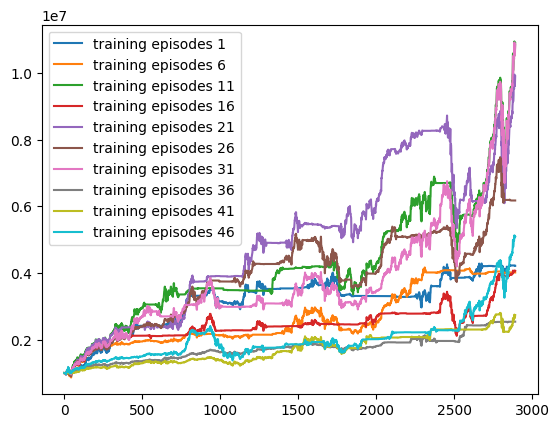

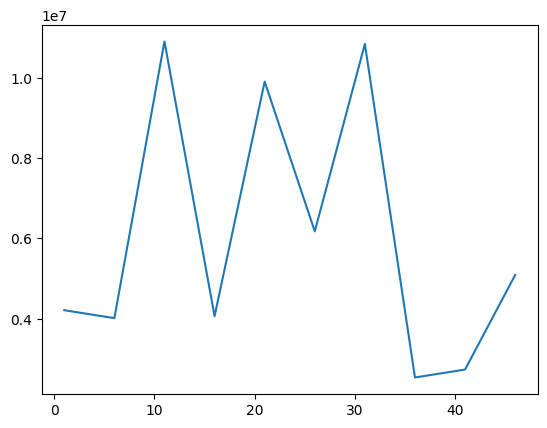

In [43]:
for e, x in zip(episodes_for_training, assets):
    plt.plot(list(range(len(x))), x, label=f"training episodes {e}")
plt.legend()
plt.show()

final_amounts = [mem[-1] for mem in assets]
plt.plot(episodes_for_training, final_amounts)
plt.show()


In [21]:
# 